In [27]:
import matplotlib.pyplot as plt
from mxnet import nd, gluon, init, context, autograd
from mxnet.gluon import nn

import re
import collections
import random

In [2]:
def read_time_machine():
    with open('./data/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line.strip().lower()) for line in lines]

In [4]:
lines = read_time_machine()
print(lines[:5])

['the time machine by h g wells ', '', '', '', '']


In [5]:
def tokenize(lines):
    tokens = [line.split(' ') for line in lines]
    return tokens

In [7]:
tokens = tokenize(lines)
print(tokens[:5])

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ''], [''], [''], [''], ['']]


In [14]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0):
        
        self.token_freqs = Vocab.count_freqs(tokens)
        self.token_freqs = sorted(self.token_freqs.items(), key=lambda x: x[0])
        self.token_freqs = sorted(self.token_freqs, key=lambda x:x[1], reverse=True)
        
        self.unk, self.uniq_tokens = 0, ['<unk>']
        self.uniq_tokens += [token for token, freq in self.token_freqs if freq > min_freq]
        
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in self.uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    @staticmethod
    def count_freqs(tokens):
        flat = [tk for line in tokens for tk in line]
        return collections.Counter(flat)
    
    def __len__(self):
        return len(self.idx_to_token)
    
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx[tokens]
        return [self.token_to_idx[token] for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(tokens, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [15]:
vocab = Vocab(tokens)

In [16]:
print(vocab.token_freqs[:10])

[('the', 2261), ('', 1282), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443)]


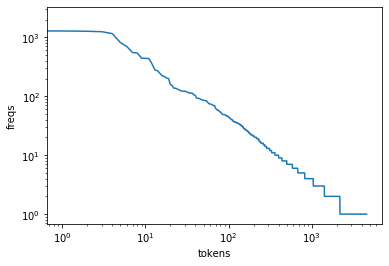

In [17]:
freqs = [freq for token, freq in vocab.token_freqs]
axes = plt.gca()
axes.set_xlabel('tokens')
axes.set_ylabel('freqs')
axes.set_xscale('log')
axes.set_yscale('log')
axes.plot(freqs)

In [18]:
digram_tokens = [[pair for pair in zip(line[:-1], line[1:])] for line in tokens]
digram_vocab = Vocab(digram_tokens)

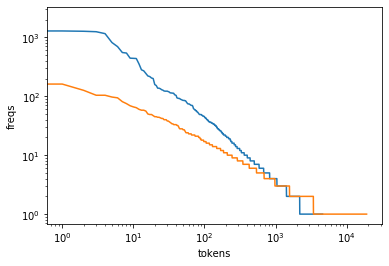

In [20]:
digram_freqs = [freq for token, freq in digram_vocab.token_freqs]
axes = plt.gca()
axes.set_xlabel('tokens')
axes.set_ylabel('freqs')
axes.set_xscale('log')
axes.set_yscale('log')
axes.plot(freqs)
axes.plot(digram_freqs)

In [21]:
trigram_tokens = [[triplet for triplet in zip(line[:-2], line[1:-1], line[2:])] for line in tokens]
trigram_vocab = Vocab(trigram_tokens)

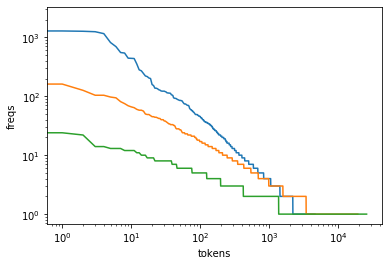

In [22]:
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
axes = plt.gca()
axes.set_xlabel('tokens')
axes.set_ylabel('freqs')
axes.set_xscale('log')
axes.set_yscale('log')
axes.plot(freqs)
axes.plot(digram_freqs)
axes.plot(trigram_freqs)

In [26]:
print(trigram_vocab.token_freqs[:5])

[(('the', 'time', 'traveller'), 53), (('the', 'time', 'machine'), 24), (('the', 'medical', 'man'), 22), (('it', 'seemed', 'to'), 14), (('it', 'was', 'a'), 14)]


Random Sampling

In [53]:
def seq_rand_data_iter(corpus, batch_size, num_steps):
    corpus = corpus[random.randint(0, num_steps):]
    num_examples = ((len(corpus) - 1) // num_steps)
    example_indices = list(range(0, num_examples*num_steps, num_steps))
    random.shuffle(example_indices)
    
    data = lambda pos: corpus[pos: pos+num_steps]
    
    num_data = num_examples // batch_size
    for i in range(0, num_data*batch_size, batch_size):
        indices = example_indices[i: (i+batch_size)]
        X = [data(j) for j in indices]
        Y = [data(j+1) for j in indices]
        yield nd.array(X), nd.array(Y)

In [54]:
seq = list(range(0, 100))
for X, y in seq_rand_data_iter(seq, 2, 5):
    print(X)
    print(y)
    break


[[78. 79. 80. 81. 82.]
 [23. 24. 25. 26. 27.]]
<NDArray 2x5 @cpu(0)>

[[79. 80. 81. 82. 83.]
 [24. 25. 26. 27. 28.]]
<NDArray 2x5 @cpu(0)>


Sequential Sampling

In [67]:
def seq_cons_data_iter(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    
    num_indices = ((len(corpus)-offset-1)//batch_size)*batch_size
    Xs = nd.array(corpus[offset:offset+num_indices])
    Ys = nd.array(corpus[offset+1:offset+1+num_indices])
    Xs = Xs.reshape((batch_size, -1))
    Ys = Ys.reshape((batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches*num_steps, num_steps):
        X = Xs[:, i:(i+num_steps)]
        y = Ys[:, i:(i+num_steps)]
        yield X, y

In [70]:
for X, y in seq_cons_data_iter(seq, 2, 6):
    print(X)
    print(y)
    break


[[ 6.  7.  8.  9. 10. 11.]
 [52. 53. 54. 55. 56. 57.]]
<NDArray 2x6 @cpu(0)>

[[ 7.  8.  9. 10. 11. 12.]
 [53. 54. 55. 56. 57. 58.]]
<NDArray 2x6 @cpu(0)>


In [71]:
def load_time_machine_corpus(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines)
    vocab = Vocab(tokens)
    corpus = [vocab[tk] for line in tokens for tk in line]
    if max_tokens > 0: corpus = corpus[:max_tokens]
    return corpus, vocab

In [72]:
corpus, vocab = load_time_machine_corpus()

In [74]:
def SeqDataLoader(object):
    def __init__(self, batch_size, num_steps, use_random, max_tokens):
        if use_random:
            data_iter = seq_rand_data_iter
        else:
            data_iter = seq_cons_data_iter
        self.corpus, self.vocab = load_time_machine_corpus(max_tokens)
        self.get_iter = lambda : data_iter(self.corpus, batch_size, num_steps)
    def __iter__(self):
        return self.get_iter()